In [1]:
print('start')
import torch
import numpy as np
from PIL import Image
import imagehash
import cv2
from shutil import rmtree
from os import mkdir,path
import matplotlib.pyplot as plt

%matplotlib inline


from torchvision import models, transforms

start


## prepare files

In [2]:
current_index=9

In [3]:
if path.isdir('test'):
    rmtree('test')
if path.isdir('results'):
    rmtree('results')

In [4]:
mkdir('test')
mkdir('test/small')
mkdir('test/crop')
mkdir('results')

In [5]:
color=(0,0,255)
thickness=2

In [6]:
small_picture = Image.open('data/google_maps/{}_small-2.png'.format(current_index)).convert('RGB')
big_picture = Image.open('data/google_maps/{}_big.png'.format(current_index)).convert('RGB')
big_picture_draw=cv2.imread('data/google_maps/{}_big.png'.format(current_index))


## prepare model

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True).to(device)

model = torch.nn.Sequential(*(list(model.children())[:-2])).to(device)

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
#     transforms.CenterCrop(10),
    transforms.ToTensor(),
    normalize
])

## working with photos

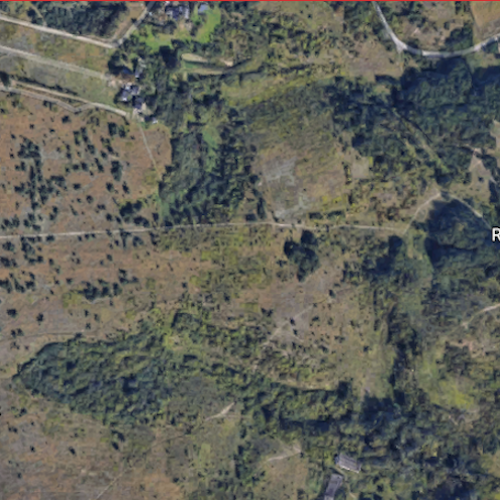

In [9]:
big_picture

In [10]:
big_picture.size

(500, 500)

In [11]:
big_picture_torch = data_transforms(big_picture).to(device)

In [12]:
big_picture_torch.size()

torch.Size([3, 500, 500])

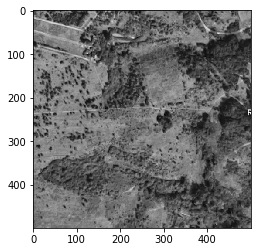

In [13]:
plt.imshow(big_picture_torch.numpy()[0], cmap='gray')

In [14]:
big_picture_torch.unsqueeze(0).size()

torch.Size([1, 3, 500, 500])

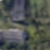

In [15]:
small_picture

## resnet

In [16]:
resnet_out_big=model(big_picture_torch.unsqueeze(0)).squeeze()

In [17]:
resnet_out_big.size()

torch.Size([2048, 16, 16])

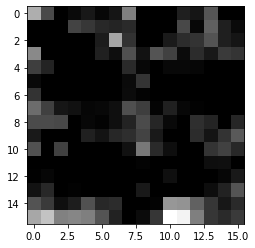

In [18]:
plt.imshow(resnet_out_big.detach().numpy()[0], cmap='gray')

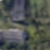

In [19]:
small_picture

In [20]:
small_picture.size

(50, 50)

In [21]:
small_picture.rotate(30).show()

In [22]:
small_pictures_rotated_torch = []
for rotate_angle in range(0,360,10):
    small_picture_rotated = small_picture.rotate(rotate_angle)
    small_pictures_rotated_torch.append(data_transforms(small_picture_rotated))

In [23]:
small_pictures_rotated_torch[0].size()

torch.Size([3, 50, 50])

In [24]:
# ,,Total number of training examples present in a single batch"
small_pictures_batch = torch.stack(small_pictures_rotated_torch).to(device)



In [25]:
small_pictures_batch.size()

torch.Size([36, 3, 50, 50])

In [26]:
resnet_outs_small = model(small_pictures_batch)

In [27]:
resnet_outs_small.size()

torch.Size([36, 2048, 2, 2])

## model outputs

In [28]:
h_big, w_big = resnet_out_big.size()[1:]
h_big, w_big

(16, 16)

In [29]:
resnet_out_big.size()

torch.Size([2048, 16, 16])

In [30]:
print(resnet_outs_small[0].size())
resnet_out_big.size()

torch.Size([2048, 2, 2])


torch.Size([2048, 16, 16])

In [31]:
min_m = 10000
min_angle = None
min_h_shift = None
min_w_shift = None

for i, resnet_out_small in enumerate(resnet_outs_small):
    h_small, w_small = resnet_out_small.size()[1:]
    for h_shift in range(h_big - h_small+1):
        for w_shift in range(w_big - w_small+1):
            resnet_out_big_cut = resnet_out_big[:, h_shift:h_shift+h_small, w_shift:w_shift+w_small]
            similarity_measure = torch.mean((resnet_out_big_cut - resnet_out_small) ** 2).item()
            if similarity_measure < min_m:
                min_m = similarity_measure
                min_angle = 10*i
                min_h_shift = h_shift
                min_w_shift = w_shift
                print(min_m, min_angle, min_h_shift, min_w_shift,resnet_out_big_cut.size())
       


        
    
    

0.9144790172576904 0 0 0 torch.Size([2048, 2, 2])
0.8887262344360352 0 0 1 torch.Size([2048, 2, 2])
0.8131430149078369 0 0 7 torch.Size([2048, 2, 2])
0.7900334000587463 0 0 8 torch.Size([2048, 2, 2])
0.768861711025238 0 1 7 torch.Size([2048, 2, 2])
0.6622190475463867 0 1 8 torch.Size([2048, 2, 2])
0.5739051103591919 0 2 8 torch.Size([2048, 2, 2])
0.5389257073402405 0 2 9 torch.Size([2048, 2, 2])
0.536008894443512 0 3 9 torch.Size([2048, 2, 2])
0.5341287851333618 0 3 10 torch.Size([2048, 2, 2])
0.49295273423194885 20 1 8 torch.Size([2048, 2, 2])
0.40016621351242065 20 2 8 torch.Size([2048, 2, 2])
0.3657083511352539 20 2 9 torch.Size([2048, 2, 2])
0.3642522096633911 20 5 5 torch.Size([2048, 2, 2])
0.3020516633987427 120 2 9 torch.Size([2048, 2, 2])
0.26500391960144043 130 2 9 torch.Size([2048, 2, 2])
0.2531602382659912 130 10 5 torch.Size([2048, 2, 2])


In [32]:
# small_picture.size
w,h=small_picture.size
print(w,h)

top_right_data=(min_h_shift*32,min_w_shift*32)
left_bottom_data=(top_right_data[0]+w,top_right_data[1]+h )
top_right_data,left_bottom_data

50 50


((320, 160), (370, 210))

In [33]:
cv2.rectangle(big_picture_draw,top_right_data,left_bottom_data,color,thickness)
cv2.imwrite('results/picture_line.png',big_picture_draw)

True

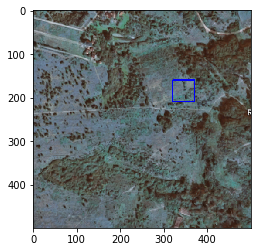

In [34]:
plt.imshow(Image.fromarray(big_picture_draw))

In [35]:
print("end")

end
